Need to manually compile and install latest master branch from github to resolve

"RuntimeError: Unsupported option activation=relu6 in layer Dense(conv1_relu)"

coremltools.converters.keras.convert('inception_model.h5',  
    input_names='image', image_input_names='image', class_labels='labels.txt',  
    red_bias=-1.0, blue_bias=-1.0, green_bias=-1.0, image_scale=2./255)  


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.applications import mobilenet

import coremltools
from coremltools.converters.keras import convert

from sutils import *

import gc
import os, json
from os import walk
from glob import glob

import pickle
import numpy as np
import math

# set path for easy working
#path = "/home/paperspace/CNNProject/dataset/"
path = "//Users/ianlo/Documents/Data Analyitcs & Data Science/Deep Learning Developer Course/CNNProject/"

os.chdir(path)

Using TensorFlow backend.


In [2]:
# test code to test the conversion of a standard mobilenet model
keras_model = mobilenet.MobileNet(input_shape=(224, 224, 3), alpha=0.25, include_top=True)
coreml_model = convert(keras_model)

# load the actual model
from keras.utils.generic_utils import CustomObjectScope

with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
    food_recog_model = load_model('food-model.831.hdf5')

0 : input_1, <keras.engine.topology.InputLayer object at 0x11bc481d0>
1 : conv1, <keras.layers.convolutional.Conv2D object at 0x10f6e8310>
2 : conv1_bn, <keras.layers.normalization.BatchNormalization object at 0x11bc80e10>
3 : conv1_relu, <keras.layers.core.Activation object at 0x11bc80a50>
4 : conv_dw_1, <keras.applications.mobilenet.DepthwiseConv2D object at 0x11bcd4dd0>
5 : conv_dw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x11bc8f7d0>
6 : conv_dw_1_relu, <keras.layers.core.Activation object at 0x11bce4fd0>
7 : conv_pw_1, <keras.layers.convolutional.Conv2D object at 0x11bd92110>
8 : conv_pw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x11be23210>
9 : conv_pw_1_relu, <keras.layers.core.Activation object at 0x11bd77510>
10 : conv_dw_2, <keras.applications.mobilenet.DepthwiseConv2D object at 0x11be90e50>
11 : conv_dw_2_bn, <keras.layers.normalization.BatchNormalization object at 0x11bef4450>
12 : conv_dw_2_relu, <keras.layers.core.Activation obje

Check that the Keras model is loaded correctly and able to predict

In [3]:
batch_size = 32
sed = 12345

datagen = image.ImageDataGenerator(
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    shear_range=0.3, 
    zoom_range=0.3,
    rescale=1./255, # scale the images
    fill_mode='nearest')

# this will subtract the mean values for inceptionv3 over imagenet
datagen.mean=np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape(1,1,3)

val_batches = get_batches(path+'/dataset/valid', gen=datagen, target_size=(224,224), batch_size=batch_size*5, shuffle=False, seed=sed)

# create index to class mapping
index_class = {}
for fclass in val_batches.class_indices.keys():
    index_class[val_batches.class_indices.get(fclass)] = fclass

output_class = [index_class[key] for key in index_class]
output_class

Found 2251 images belonging to 17 classes.


['bak_kut_teh',
 'braised_duck_rice',
 'char_kway_teow',
 'chili_crab',
 'hokkien_mee',
 'kueh_pie_tee',
 'kway_chap',
 'mee_goreng',
 'mee_rebus',
 'nasi_lemak',
 'popiah',
 'prawn_noodle',
 'roast_chicken_rice',
 'roti_prata',
 'satay',
 'wanton_mee',
 'white_chicken_rice']

In [5]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

name = 'wanton_mee-N-20.jpg'
image_path = "./dataset/valid/wanton_mee/"
#image_path = "./valid/white_chicken_rice/"
#image_path = "./valid/bak_kut_teh/"
#image_path = "./valid/braised_duck_rice/"
#image_path = "./valid/mee_rebus/"

img_path = os.path.join(image_path, name)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = preprocess_input(x, data_format='channels_first')
x *= 1./255
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

('Input image shape:', (1, 224, 224, 3))


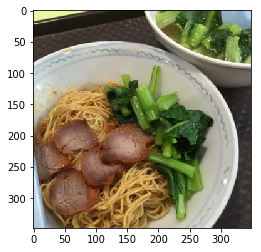

In [6]:
def show_image(name):
    img_path = os.path.join(image_path, name)
    img=mpimg.imread(img_path)
    plt.imshow(img)
    
show_image(name)

In [7]:
preds = food_recog_model.predict(x)
#print('Predicted:', preds)

In [8]:
result = index_class.get(np.argmax(preds))
print(result)

wanton_mee


Because the Keras model was trained on ImageNet, need to subtract the mean from RGB

- red_bias=-123.68
- green_bias=-116.78
- blue_bias=-103.94

In [9]:

scale = 1./255
coreml_model = coremltools.converters.keras.convert(food_recog_model,
                                                    input_names = 'image',
                                                    output_names = 'output',
                                                    image_input_names = 'image',
                                                    image_scale = scale,
                                                    red_bias = -123.68 * scale,
                                                    green_bias = -116.779 * scale,
                                                    blue_bias = -103.939 * scale,
                                                    class_labels=output_class)

coreml_model.author = 'Ian Lo'
coreml_model.license = 'MIT'
coreml_model.short_description = 'Model to classify 17 different Singaporean dishes'
coreml_model.input_description['image'] = 'Images from camera in CVPixelBuffer'
coreml_model.output_description['output'] = 'Predicted dishes'

coreml_model.save('food_recog_model.mlmodel')

0 : input_2, <keras.engine.topology.InputLayer object at 0x11dcba210>
1 : conv1, <keras.layers.convolutional.Conv2D object at 0x11db98850>
2 : conv1_bn, <keras.layers.normalization.BatchNormalization object at 0x11db98910>
3 : conv1_relu, <keras.layers.core.Activation object at 0x11dbd8250>
4 : conv_dw_1, <keras.applications.mobilenet.DepthwiseConv2D object at 0x11dc7d950>
5 : conv_dw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x11dbc4810>
6 : conv_dw_1_relu, <keras.layers.core.Activation object at 0x11dc7d2d0>
7 : conv_pw_1, <keras.layers.convolutional.Conv2D object at 0x11db66390>
8 : conv_pw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x11dc4fa10>
9 : conv_pw_1_relu, <keras.layers.core.Activation object at 0x11dc3e290>
10 : conv_dw_2, <keras.applications.mobilenet.DepthwiseConv2D object at 0x11dca4890>
11 : conv_dw_2_bn, <keras.layers.normalization.BatchNormalization object at 0x11dc14410>
12 : conv_dw_2_relu, <keras.layers.core.Activation obje